<a href="https://colab.research.google.com/github/MEGlantz/Russian_Presidents_NLP/blob/main/KremlinTranscriptPreProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading Libraries and Data

In [6]:
pip install fasttext


In [7]:
pip install contractions

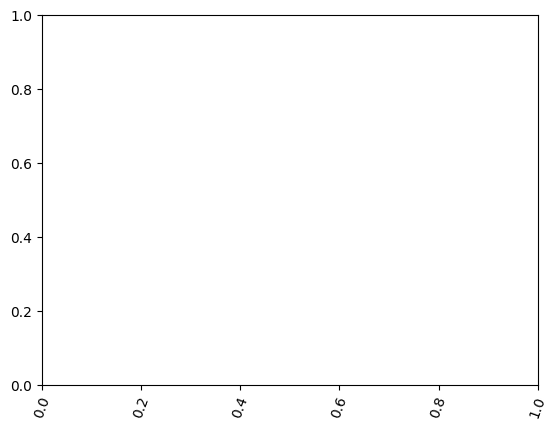

In [8]:
# import necessary libraries
import pandas as pd
import numpy as np
import nltk
import string
import fasttext
import contractions
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import MWETokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

plt.xticks(rotation=70)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
%matplotlib inline


In [9]:
import json

In [12]:
# import data into pandas dataframe

data = []
with open('/content/drive/MyDrive/Kremlin Transcripts August 2023/transcripts_en_2023-08-30.json', 'r') as file:
    for line in file:
        try:
            json_data = json.loads(line)
            data.append(json_data)
        except json.JSONDecodeError:
            print(f"Invalid JSON data: {line}")

df = pd.DataFrame(data)



In [13]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9623 entries, 0 to 9622
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   date                   9623 non-null   object
 1   persons                9623 non-null   object
 2   transcript_unfiltered  9623 non-null   object
 3   kremlin_id             9623 non-null   int64 
 4   place                  9623 non-null   object
 5   title                  9623 non-null   object
 6   teaser                 9623 non-null   object
 7   tags                   9623 non-null   object
 8   transcript_filtered    9623 non-null   object
 9   wordlist               9623 non-null   object
dtypes: int64(1), object(9)
memory usage: 751.9+ KB


In [14]:
# it looks like there are no null values, but check
for col in df.columns:
    print(col, df[col].isnull().sum())

date 0
persons 0
transcript_unfiltered 0
kremlin_id 0
place 0
title 0
teaser 0
tags 0
transcript_filtered 0
wordlist 0


In [15]:
df.sample(5)  # Display a random sample of 5 rows


,date,persons,transcript_unfiltered,kremlin_id,place,title,teaser,tags,transcript_filtered,wordlist
556,2002-12-17T00:02:00,[],"Vladimir Putin: Dear ladies and gentlemen, allow me to inform you briefly about the results of o...",21815,"The Kremlin, Moscow",Statement Following Talks with President Ali Abdallah Salih of the Republic of Yemen,,[],"Dear ladies and gentlemen, allow me to inform you briefly about the results of our work. Our tal...","[dear, lady, and, gentleman, ,, allow, I, to, inform, you, briefly, about, the, result, of, our,..."
5397,2014-08-14T20:45:00,[],The discussion focussed on international policy issues. The meeting took place in the Livadia Pa...,46454,Yalta,Meeting with leader of the Mouvement pour la France party Philippe de Villiers,"Vladimir Putin met with French politician, leader of the Mouvement pour la France party Philippe...",[Foreign policy],"Mr de Villiers, it is a pleasure to meet you and see you here. I know that you have created one ...","[Mr, de, Villiers, ,, it, be, a, pleasure, to, meet, you, and, see, you, here, ., , I, know, th..."
8686,2021-05-25T15:25:00,[],"The meeting was attended by Defence Minister Sergei Shoigu Shoigu SergeiDefence Minister , C...",65653,Sochi,Meeting with Defence Ministry leadership and heads of defence industry enterprises,The President held the first in a series of meetings on defence issues. The discussion focused o...,"[Armed Forces, National security]","Good afternoon, colleagues, Today we are beginning the traditional spring series of meetings on ...","[good, afternoon, ,, colleague, ,, today, we, be, begin, the, traditional, spring, series, of, m..."
8878,2021-11-02T14:30:00,[],The discussion focused on equipping the Armed Forces with unmanned aircraft. The meeting was att...,67056,Sochi,Meeting with Defence Ministry leadership and heads of defence industry enterprises,"In Sochi, Vladimir Putin chaired the second meeting with Defence Ministry leadership and heads o...","[Armed Forces, National security]","Good afternoon, colleagues. Today we will continue our work and discuss the development of unman...","[good, afternoon, ,, colleague, ., , today, we, will, continue, our, work, and, discuss, the, d..."
1031,2004-08-20T00:00:00,[],"President Vladimir Putin: Good afternoon, ladies and gentlemen. Allow us to briefly inform you o...",22576,Sochi,Extracts from the Press Conference Following a Meeting with President of Armenia Robert Kocharian,,[],"Good afternoon, ladies and gentlemen. Allow us to briefly inform you on our work today. First of...","[good, afternoon, ,, lady, and, gentleman, ., , allow, we, to, briefly, inform, you, on, our, w..."


In [16]:
# Drop unneeded columns
columns_to_drop = ['kremlin_id', 'teaser', 'tags', 'transcript_filtered', 'wordlist']

df = df.drop(columns=columns_to_drop)

In [17]:
sample_transcripts = df['transcript_unfiltered'].sample(5)
print(sample_transcripts)


3292    President of Russia Dmitry Medvedev: Colleagues, the time has come to examine the latest round o...
2753    President of Russia Dmitry Medvedev: Dear comrades! I would like to say a few words before our m...
8869    Taking part in the meeting were Deputy Prime Minister Alexander Novak     Novak AlexanderDeputy ...
8978    President of Russia Vladimir Putin: Good afternoon. Minister of Justice Konstantin Chuychenko: G...
7006    The general topic of the Valdai Club this year is Creative Destruction: Will a New World Order E...
Name: transcript_unfiltered, dtype: object


In [18]:
print(df['transcript_unfiltered'].dtype)

object


### Text Preprocessing

#### Expand Contractions

In [19]:
# Expand contractions in "transcript_unfiltered" column

df['no_contract'] = df['transcript_unfiltered'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [20]:
# Create column with transcript with expanded contractions called "transcript_unfiltered_str"

df['transcript_unfiltered_str'] = [' '.join(map(str, l)) for l in df['no_contract']]
df.head()

,date,persons,transcript_unfiltered,place,title,no_contract,transcript_unfiltered_str
0,1999-12-31T00:01:00,[],"Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...","The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,"[Vladimir, Putin:, Dear, friends,, On, New, Year’s, Eve,, my, family, and, I, planned, to, gathe...","Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,..."
1,1999-12-31T00:02:00,[],"Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...","The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,"[Vladimir, Putin:, Good, afternoon,, distinguished, colleagues., This, will, be, a, short, meeti...","Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask..."
2,1999-12-31T00:03:00,[],"Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...","The Kremlin, Moscow",Statement by Boris Yeltsin,"[Boris, Yeltsin:, Dear, Russians,, In, a, few, hours, we, will, see, a, magical, date, on, our, ...","Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye..."
3,2000-01-04T00:00:00,[],"Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",Moscow,Interview with the ORT TV Channel,"[Question:, Mr, Putin,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, question...","Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou..."
4,2000-01-11T00:00:00,[],"Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...","State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,"[Vladimir, Putin:, Dear, friends,, We, are, again, gathered, here, today,, this, time, on, the, ...","Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the..."


#### Detect (and remove) non-English Words

In [21]:
import io


pretrained_model = "/content/drive/MyDrive/DATA 495/lid.176.bin"
model = fasttext.load_model(pretrained_model)
langs = []
for sent in df['transcript_unfiltered_str']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[11:13])
df['langs'] = langs

#### Tokenize

In [22]:
nltk.download('punkt')

# punkt is a sentence tokenizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [23]:
# tokenize transcript into words

df['transcripts_word_tokenized'] = df['transcript_unfiltered_str'].apply(word_tokenize)
df.head()

,date,persons,transcript_unfiltered,place,title,no_contract,transcript_unfiltered_str,langs,transcripts_word_tokenized
0,1999-12-31T00:01:00,[],"Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...","The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,"[Vladimir, Putin:, Dear, friends,, On, New, Year’s, Eve,, my, family, and, I, planned, to, gathe...","Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...",en,"[Vladimir, Putin, :, Dear, friends, ,, On, New, Year, ’, s, Eve, ,, my, family, and, I, planned,..."
1,1999-12-31T00:02:00,[],"Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...","The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,"[Vladimir, Putin:, Good, afternoon,, distinguished, colleagues., This, will, be, a, short, meeti...","Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...",en,"[Vladimir, Putin, :, Good, afternoon, ,, distinguished, colleagues, ., This, will, be, a, short,..."
2,1999-12-31T00:03:00,[],"Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...","The Kremlin, Moscow",Statement by Boris Yeltsin,"[Boris, Yeltsin:, Dear, Russians,, In, a, few, hours, we, will, see, a, magical, date, on, our, ...","Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...",en,"[Boris, Yeltsin, :, Dear, Russians, ,, In, a, few, hours, we, will, see, a, magical, date, on, o..."
3,2000-01-04T00:00:00,[],"Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",Moscow,Interview with the ORT TV Channel,"[Question:, Mr, Putin,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, question...","Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",en,"[Question, :, Mr, Putin, ,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, ques..."
4,2000-01-11T00:00:00,[],"Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...","State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,"[Vladimir, Putin:, Dear, friends,, We, are, again, gathered, here, today,, this, time, on, the, ...","Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...",en,"[Vladimir, Putin, :, Dear, friends, ,, We, are, again, gathered, here, today, ,, this, time, on,..."


In [26]:
# tokenize transcripts by sentence

df['transcripts_sentence_tokenized'] = df['transcript_unfiltered_str'].apply(sent_tokenize)
df.head()

,date,persons,transcript_unfiltered,place,title,no_contract,transcript_unfiltered_str,langs,transcripts_word_tokenized,transcripts_sentence_tokenized
0,1999-12-31T00:01:00,[],"Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...","The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,"[Vladimir, Putin:, Dear, friends,, On, New, Year’s, Eve,, my, family, and, I, planned, to, gathe...","Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...",en,"[Vladimir, Putin, :, Dear, friends, ,, On, New, Year, ’, s, Eve, ,, my, family, and, I, planned,...","[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV..."
1,1999-12-31T00:02:00,[],"Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...","The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,"[Vladimir, Putin:, Good, afternoon,, distinguished, colleagues., This, will, be, a, short, meeti...","Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...",en,"[Vladimir, Putin, :, Good, afternoon, ,, distinguished, colleagues, ., This, will, be, a, short,...","[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ..."
2,1999-12-31T00:03:00,[],"Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...","The Kremlin, Moscow",Statement by Boris Yeltsin,"[Boris, Yeltsin:, Dear, Russians,, In, a, few, hours, we, will, see, a, magical, date, on, our, ...","Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...",en,"[Boris, Yeltsin, :, Dear, Russians, ,, In, a, few, hours, we, will, see, a, magical, date, on, o...","[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y..."
3,2000-01-04T00:00:00,[],"Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",Moscow,Interview with the ORT TV Channel,"[Question:, Mr, Putin,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, question...","Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",en,"[Question, :, Mr, Putin, ,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, ques...","[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co..."
4,2000-01-11T00:00:00,[],"Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...","State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,"[Vladimir, Putin:, Dear, friends,, We, are, again, gathered, here, today,, this, time, on, the, ...","Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...",en,"[Vladimir, Putin, :, Dear, friends, ,, We, are, again, gathered, here, today, ,, this, time, on,...","[Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of th..."


##### Combine key words, abbreviations, etc back into phrases

In [27]:


tokenizedwords_list = df['transcripts_word_tokenized'].tolist()

# Flatten the list of lists to get a single list of words
all_words = [word for sublist in tokenizedwords_list for word in sublist]





In [30]:
# search for words around key words to identify necessary phrases
from nltk.text import Text


text = Text(all_words)

# Find concordances for specific target words
text.concordance("America", width=10)
text.concordance("States", width=50)
text.concordance("Atlantic", width=10)
text.concordance("Missile", width=10)
text.concordance("revolutions", width=30)
text.concordance("Eurasia", width=10)
text.concordance("defense", width =20)
text.concordance("NATO", width = 10)
text.concordance("China", width = 50)



Displaying 25 of 1385 matches:
and Latin America 
in North America 
States of America 
in Latin America 
some of America 
, North America 
in North America 
proposed by America 
less than America 
or Latin America 
or North America 
, as America 
, Central America 
situation like America 
and North America 
and North America 
and North America 
Europe and America 
to North America 
and Latin America 
in Latin America 
its Latin America 
in Latin America 
of Latin America 
, Latin America 
Displaying 25 of 8964 matches:
wealth of Independent States . As to the issue of 
 named and with other states . There are ways to m
wealth of Independent States , and Alexander Grigo
ther heads of the CIS states said that we should n
ts of our peoples and states . I said : “ Mr Putin
cooperation with some states . This does not mean 
e on the part of many states to make integration i
tion to benefit those states that have shown inter
gain , there are such states . Vladimir Putin : De
an Union , the U

#### Lowercase, no punctuation, etc...


In [31]:
df['lower'] = df['transcripts_word_tokenized'].apply(lambda x: [word.lower() for word in x])
df.head()

,date,persons,transcript_unfiltered,place,title,no_contract,transcript_unfiltered_str,langs,transcripts_word_tokenized,transcripts_sentence_tokenized,lower
0,1999-12-31T00:01:00,[],"Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...","The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,"[Vladimir, Putin:, Dear, friends,, On, New, Year’s, Eve,, my, family, and, I, planned, to, gathe...","Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...",en,"[Vladimir, Putin, :, Dear, friends, ,, On, New, Year, ’, s, Eve, ,, my, family, and, I, planned,...","[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, :, dear, friends, ,, on, new, year, ’, s, eve, ,, my, family, and, i, planned,..."
1,1999-12-31T00:02:00,[],"Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...","The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,"[Vladimir, Putin:, Good, afternoon,, distinguished, colleagues., This, will, be, a, short, meeti...","Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...",en,"[Vladimir, Putin, :, Good, afternoon, ,, distinguished, colleagues, ., This, will, be, a, short,...","[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, :, good, afternoon, ,, distinguished, colleagues, ., this, will, be, a, short,..."
2,1999-12-31T00:03:00,[],"Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...","The Kremlin, Moscow",Statement by Boris Yeltsin,"[Boris, Yeltsin:, Dear, Russians,, In, a, few, hours, we, will, see, a, magical, date, on, our, ...","Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...",en,"[Boris, Yeltsin, :, Dear, Russians, ,, In, a, few, hours, we, will, see, a, magical, date, on, o...","[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, :, dear, russians, ,, in, a, few, hours, we, will, see, a, magical, date, on, o..."
3,2000-01-04T00:00:00,[],"Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",Moscow,Interview with the ORT TV Channel,"[Question:, Mr, Putin,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, question...","Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",en,"[Question, :, Mr, Putin, ,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, ques...","[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, :, mr, putin, ,, the, sudden, resignation, of, mr, yeltsin, has, prompted, many, ques..."
4,2000-01-11T00:00:00,[],"Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...","State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,"[Vladimir, Putin:, Dear, friends,, We, are, again, gathered, here, today,, this, time, on, the, ...","Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...",en,"[Vladimir, Putin, :, Dear, friends, ,, We, are, again, gathered, here, today, ,, this, time, on,...","[Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of th...","[vladimir, putin, :, dear, friends, ,, we, are, again, gathered, here, today, ,, this, time, on,..."


In [32]:
# recombine some of the words into phrase tokens

# create list of tuples to be combined into phrases using nltk mwetokenizer

mwe_list = [("north", "america"), ("colored", "revolutions"), ("commonwealth", "of", "independent", "states"), ("anti-ballistic", "missile", "defense"),
            ("missile", "defense"), ("european", "union"), ("eurasian", "economic", "union"), ("north", "atlantic", "treaty", "organization"),
            ("united", "nations"), ("security", "council")]

# Create an MWE tokenizer using the list of MWEs
mwe_tokenizer = nltk.MWETokenizer(mwe_list)

# Tokenize your the lower case word transcripts with the MWE tokenizer
df['transcripts_phrase_tokenized'] = df['lower'].apply(mwe_tokenizer.tokenize)

In [33]:
df.head()

,date,persons,transcript_unfiltered,place,title,no_contract,transcript_unfiltered_str,langs,transcripts_word_tokenized,transcripts_sentence_tokenized,lower,transcripts_phrase_tokenized
0,1999-12-31T00:01:00,[],"Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...","The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,"[Vladimir, Putin:, Dear, friends,, On, New, Year’s, Eve,, my, family, and, I, planned, to, gathe...","Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...",en,"[Vladimir, Putin, :, Dear, friends, ,, On, New, Year, ’, s, Eve, ,, my, family, and, I, planned,...","[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, :, dear, friends, ,, on, new, year, ’, s, eve, ,, my, family, and, i, planned,...","[vladimir, putin, :, dear, friends, ,, on, new, year, ’, s, eve, ,, my, family, and, i, planned,..."
1,1999-12-31T00:02:00,[],"Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...","The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,"[Vladimir, Putin:, Good, afternoon,, distinguished, colleagues., This, will, be, a, short, meeti...","Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...",en,"[Vladimir, Putin, :, Good, afternoon, ,, distinguished, colleagues, ., This, will, be, a, short,...","[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, :, good, afternoon, ,, distinguished, colleagues, ., this, will, be, a, short,...","[vladimir, putin, :, good, afternoon, ,, distinguished, colleagues, ., this, will, be, a, short,..."
2,1999-12-31T00:03:00,[],"Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...","The Kremlin, Moscow",Statement by Boris Yeltsin,"[Boris, Yeltsin:, Dear, Russians,, In, a, few, hours, we, will, see, a, magical, date, on, our, ...","Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...",en,"[Boris, Yeltsin, :, Dear, Russians, ,, In, a, few, hours, we, will, see, a, magical, date, on, o...","[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, :, dear, russians, ,, in, a, few, hours, we, will, see, a, magical, date, on, o...","[boris, yeltsin, :, dear, russians, ,, in, a, few, hours, we, will, see, a, magical, date, on, o..."
3,2000-01-04T00:00:00,[],"Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",Moscow,Interview with the ORT TV Channel,"[Question:, Mr, Putin,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, question...","Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",en,"[Question, :, Mr, Putin, ,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, ques...","[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, :, mr, putin, ,, the, sudden, resignation, of, mr, yeltsin, has, prompted, many, ques...","[question, :, mr, putin, ,, the, sudden, resignation, of, mr, yeltsin, has, prompted, many, ques..."
4,2000-01-11T00:00:00,[],"Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...","State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,"[Vladimir, Putin:, Dear, friends,, We, are, again, gathered, here, today,, this, time, on, the, ...","Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...",en,"[Vladimir, Putin, :, Dear, friends, ,, We, are, again, gathered, here, today, ,, this, time, on,...","[Vladimir Putin: Dear friends, We are again gathered here 

In [34]:
# remove punctuation
punc = string.punctuation
df['no_punc'] = df['transcripts_phrase_tokenized'].apply(lambda x: [word for word in x if word not in punc])
df.head()

,date,persons,transcript_unfiltered,place,title,no_contract,transcript_unfiltered_str,langs,transcripts_word_tokenized,transcripts_sentence_tokenized,lower,transcripts_phrase_tokenized,no_punc
0,1999-12-31T00:01:00,[],"Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...","The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,"[Vladimir, Putin:, Dear, friends,, On, New, Year’s, Eve,, my, family, and, I, planned, to, gathe...","Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...",en,"[Vladimir, Putin, :, Dear, friends, ,, On, New, Year, ’, s, Eve, ,, my, family, and, I, planned,...","[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, :, dear, friends, ,, on, new, year, ’, s, eve, ,, my, family, and, i, planned,...","[vladimir, putin, :, dear, friends, ,, on, new, year, ’, s, eve, ,, my, family, and, i, planned,...","[vladimir, putin, dear, friends, on, new, year, ’, s, eve, my, family, and, i, planned, to, gath..."
1,1999-12-31T00:02:00,[],"Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...","The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,"[Vladimir, Putin:, Good, afternoon,, distinguished, colleagues., This, will, be, a, short, meeti...","Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...",en,"[Vladimir, Putin, :, Good, afternoon, ,, distinguished, colleagues, ., This, will, be, a, short,...","[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, :, good, afternoon, ,, distinguished, colleagues, ., this, will, be, a, short,...","[vladimir, putin, :, good, afternoon, ,, distinguished, colleagues, ., this, will, be, a, short,...","[vladimir, putin, good, afternoon, distinguished, colleagues, this, will, be, a, short, meeting,..."
2,1999-12-31T00:03:00,[],"Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...","The Kremlin, Moscow",Statement by Boris Yeltsin,"[Boris, Yeltsin:, Dear, Russians,, In, a, few, hours, we, will, see, a, magical, date, on, our, ...","Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...",en,"[Boris, Yeltsin, :, Dear, Russians, ,, In, a, few, hours, we, will, see, a, magical, date, on, o...","[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, :, dear, russians, ,, in, a, few, hours, we, will, see, a, magical, date, on, o...","[boris, yeltsin, :, dear, russians, ,, in, a, few, hours, we, will, see, a, magical, date, on, o...","[boris, yeltsin, dear, russians, in, a, few, hours, we, will, see, a, magical, date, on, our, ca..."
3,2000-01-04T00:00:00,[],"Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",Moscow,Interview with the ORT TV Channel,"[Question:, Mr, Putin,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, question...","Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",en,"[Question, :, Mr, Putin, ,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, ques...","[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, :, mr, putin, ,, the, sudden, resignation, of, mr, yeltsin, has, prompted, many, ques...","[question, :, mr, putin, ,, the, sudden, resignation, of, mr, yeltsin, has, prompted, many, ques...","[question, mr, putin, the, sudden, resignation, of, mr, yeltsin, has, prompted, many, questions,..."
4,2000-01-11T00:00:00,[],"Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of the...","State Kremlin Palace, Moscow",Speech at gala function 

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [36]:
# remove stopwords

stop_words = set(stopwords.words('english'))
df['stopwords_removed'] = df['no_punc'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,date,persons,transcript_unfiltered,place,title,no_contract,transcript_unfiltered_str,langs,transcripts_word_tokenized,transcripts_sentence_tokenized,lower,transcripts_phrase_tokenized,no_punc,stopwords_removed
0,1999-12-31T00:01:00,[],"Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...","The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,"[Vladimir, Putin:, Dear, friends,, On, New, Year’s, Eve,, my, family, and, I, planned, to, gathe...","Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV,...",en,"[Vladimir, Putin, :, Dear, friends, ,, On, New, Year, ’, s, Eve, ,, my, family, and, I, planned,...","[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, :, dear, friends, ,, on, new, year, ’, s, eve, ,, my, family, and, i, planned,...","[vladimir, putin, :, dear, friends, ,, on, new, year, ’, s, eve, ,, my, family, and, i, planned,...","[vladimir, putin, dear, friends, on, new, year, ’, s, eve, my, family, and, i, planned, to, gath...","[vladimir, putin, dear, friends, new, year, ’, eve, family, planned, gather, round, tv, probably..."
1,1999-12-31T00:02:00,[],"Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...","The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,"[Vladimir, Putin:, Good, afternoon,, distinguished, colleagues., This, will, be, a, short, meeti...","Vladimir Putin: Good afternoon, distinguished colleagues. This will be a short meeting. I am ask...",en,"[Vladimir, Putin, :, Good, afternoon, ,, distinguished, colleagues, ., This, will, be, a, short,...","[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, :, good, afternoon, ,, distinguished, colleagues, ., this, will, be, a, short,...","[vladimir, putin, :, good, afternoon, ,, distinguished, colleagues, ., this, will, be, a, short,...","[vladimir, putin, good, afternoon, distinguished, colleagues, this, will, be, a, short, meeting,...","[vladimir, putin, good, afternoon, distinguished, colleagues, short, meeting, asking, continue, ..."
2,1999-12-31T00:03:00,[],"Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...","The Kremlin, Moscow",Statement by Boris Yeltsin,"[Boris, Yeltsin:, Dear, Russians,, In, a, few, hours, we, will, see, a, magical, date, on, our, ...","Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the ye...",en,"[Boris, Yeltsin, :, Dear, Russians, ,, In, a, few, hours, we, will, see, a, magical, date, on, o...","[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, :, dear, russians, ,, in, a, few, hours, we, will, see, a, magical, date, on, o...","[boris, yeltsin, :, dear, russians, ,, in, a, few, hours, we, will, see, a, magical, date, on, o...","[boris, yeltsin, dear, russians, in, a, few, hours, we, will, see, a, magical, date, on, our, ca...","[boris, yeltsin, dear, russians, hours, see, magical, date, calendars, year, 2000, new, century,..."
3,2000-01-04T00:00:00,[],"Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",Moscow,Interview with the ORT TV Channel,"[Question:, Mr, Putin,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, question...","Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this cou...",en,"[Question, :, Mr, Putin, ,, the, sudden, resignation, of, Mr, Yeltsin, has, prompted, many, ques...","[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, :, mr, putin, ,, the, sudden, resignation, of, mr, yeltsin, has, prompted, many, ques...","[question, :, mr, putin, ,, the, sudden, resignation, of, mr,

In [37]:
# drop newly unnecessary columns (we created the column we really want)
# this should leave us with just the sentence tokenized and the cleaned phrase
# tokenized columns (plus place and date and language)

columns_to_drop2 = ['transcript_unfiltered', 'no_contract', 'transcript_unfiltered_str', 'transcripts_word_tokenized',
                    'lower', 'no_punc', 'transcripts_phrase_tokenized']

df_clean = df.drop(columns=columns_to_drop2)
df_clean.head()



,date,persons,place,title,langs,transcripts_sentence_tokenized,stopwords_removed
0,1999-12-31T00:01:00,[],"The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,en,"[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, dear, friends, new, year, ’, eve, family, planned, gather, round, tv, probably..."
1,1999-12-31T00:02:00,[],"The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,en,"[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, good, afternoon, distinguished, colleagues, short, meeting, asking, continue, ..."
2,1999-12-31T00:03:00,[],"The Kremlin, Moscow",Statement by Boris Yeltsin,en,"[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, dear, russians, hours, see, magical, date, calendars, year, 2000, new, century,..."
3,2000-01-04T00:00:00,[],Moscow,Interview with the ORT TV Channel,en,"[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, mr, putin, sudden, resignation, mr, yeltsin, prompted, many, questions, country, abro..."
4,2000-01-11T00:00:00,[],"State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,en,"[Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of th...","[vladimir, putin, dear, friends, gathered, today, time, occasion, joyful, celebration, christ, ’..."


#### Lemmatization

There is some debate over whether stemming or lemmatization is most useful, but it seems lemmatization is better when context matters.

In [38]:
 nltk.download('averaged_perceptron_tagger')

# apply part of speech tags
df_clean['pos_tags'] = df_clean['stopwords_removed'].apply(nltk.tag.pos_tag)
df_clean.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,date,persons,place,title,langs,transcripts_sentence_tokenized,stopwords_removed,pos_tags
0,1999-12-31T00:01:00,[],"The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,en,"[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, dear, friends, new, year, ’, eve, family, planned, gather, round, tv, probably...","[(vladimir, NN), (putin, NN), (dear, JJ), (friends, NNS), (new, JJ), (year, NN), (’, NN), (eve, ..."
1,1999-12-31T00:02:00,[],"The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,en,"[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, good, afternoon, distinguished, colleagues, short, meeting, asking, continue, ...","[(vladimir, NN), (putin, NN), (good, JJ), (afternoon, NN), (distinguished, VBD), (colleagues, NN..."
2,1999-12-31T00:03:00,[],"The Kremlin, Moscow",Statement by Boris Yeltsin,en,"[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, dear, russians, hours, see, magical, date, calendars, year, 2000, new, century,...","[(boris, NN), (yeltsin, NN), (dear, JJ), (russians, NNS), (hours, NNS), (see, VBP), (magical, JJ..."
3,2000-01-04T00:00:00,[],Moscow,Interview with the ORT TV Channel,en,"[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, mr, putin, sudden, resignation, mr, yeltsin, prompted, many, questions, country, abro...","[(question, NN), (mr, NN), (putin, NN), (sudden, JJ), (resignation, NN), (mr, NN), (yeltsin, NN)..."
4,2000-01-11T00:00:00,[],"State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,en,"[Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of th...","[vladimir, putin, dear, friends, gathered, today, time, occasion, joyful, celebration, christ, ’...","[(vladimir, NN), (putin, NN), (dear, JJ), (friends, NNS), (gathered, VBN), (today, NN), (time, N..."


In [39]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [40]:
# function to convert pos tag to wordnet format for nltk
# source:  https://towardsdatascience.com/preprocessing-text-data-using-python-576206753c28

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df_clean['wordnet_pos'] = df_clean['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
df_clean.head()

,date,persons,place,title,langs,transcripts_sentence_tokenized,stopwords_removed,pos_tags,wordnet_pos
0,1999-12-31T00:01:00,[],"The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,en,"[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, dear, friends, new, year, ’, eve, family, planned, gather, round, tv, probably...","[(vladimir, NN), (putin, NN), (dear, JJ), (friends, NNS), (new, JJ), (year, NN), (’, NN), (eve, ...","[(vladimir, n), (putin, n), (dear, a), (friends, n), (new, a), (year, n), (’, n), (eve, v), (fam..."
1,1999-12-31T00:02:00,[],"The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,en,"[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, good, afternoon, distinguished, colleagues, short, meeting, asking, continue, ...","[(vladimir, NN), (putin, NN), (good, JJ), (afternoon, NN), (distinguished, VBD), (colleagues, NN...","[(vladimir, n), (putin, n), (good, a), (afternoon, n), (distinguished, v), (colleagues, n), (sho..."
2,1999-12-31T00:03:00,[],"The Kremlin, Moscow",Statement by Boris Yeltsin,en,"[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, dear, russians, hours, see, magical, date, calendars, year, 2000, new, century,...","[(boris, NN), (yeltsin, NN), (dear, JJ), (russians, NNS), (hours, NNS), (see, VBP), (magical, JJ...","[(boris, n), (yeltsin, n), (dear, a), (russians, n), (hours, n), (see, v), (magical, a), (date, ..."
3,2000-01-04T00:00:00,[],Moscow,Interview with the ORT TV Channel,en,"[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, mr, putin, sudden, resignation, mr, yeltsin, prompted, many, questions, country, abro...","[(question, NN), (mr, NN), (putin, NN), (sudden, JJ), (resignation, NN), (mr, NN), (yeltsin, NN)...","[(question, n), (mr, n), (putin, n), (sudden, a), (resignation, n), (mr, n), (yeltsin, n), (prom..."
4,2000-01-11T00:00:00,[],"State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,en,"[Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of th...","[vladimir, putin, dear, friends, gathered, today, time, occasion, joyful, celebration, christ, ’...","[(vladimir, NN), (putin, NN), (dear, JJ), (friends, NNS), (gathered, VBN), (today, NN), (time, N...","[(vladimir, n), (putin, n), (dear, a), (friends, n), (gathered, v), (today, n), (time, n), (occa..."


In [41]:
# Apply NLTK WordNetLemmatizer

wnl = WordNetLemmatizer()
df_clean['lemmatized'] = df_clean['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df_clean.head()

,date,persons,place,title,langs,transcripts_sentence_tokenized,stopwords_removed,pos_tags,wordnet_pos,lemmatized
0,1999-12-31T00:01:00,[],"The Kremlin, Moscow",New Year Address by Acting President Vladimir Putin,en,"[Vladimir Putin: Dear friends, On New Year’s Eve, my family and I planned to gather round the TV...","[vladimir, putin, dear, friends, new, year, ’, eve, family, planned, gather, round, tv, probably...","[(vladimir, NN), (putin, NN), (dear, JJ), (friends, NNS), (new, JJ), (year, NN), (’, NN), (eve, ...","[(vladimir, n), (putin, n), (dear, a), (friends, n), (new, a), (year, n), (’, n), (eve, v), (fam...","[vladimir, putin, dear, friend, new, year, ’, eve, family, plan, gather, round, tv, probably, li..."
1,1999-12-31T00:02:00,[],"The Kremlin, Moscow",Address at an expanded meeting of the Russian Security Council,en,"[Vladimir Putin: Good afternoon, distinguished colleagues., This will be a short meeting., I am ...","[vladimir, putin, good, afternoon, distinguished, colleagues, short, meeting, asking, continue, ...","[(vladimir, NN), (putin, NN), (good, JJ), (afternoon, NN), (distinguished, VBD), (colleagues, NN...","[(vladimir, n), (putin, n), (good, a), (afternoon, n), (distinguished, v), (colleagues, n), (sho...","[vladimir, putin, good, afternoon, distinguish, colleague, short, meeting, ask, continue, work, ..."
2,1999-12-31T00:03:00,[],"The Kremlin, Moscow",Statement by Boris Yeltsin,en,"[Boris Yeltsin: Dear Russians, In a few hours we will see a magical date on our calendars, the y...","[boris, yeltsin, dear, russians, hours, see, magical, date, calendars, year, 2000, new, century,...","[(boris, NN), (yeltsin, NN), (dear, JJ), (russians, NNS), (hours, NNS), (see, VBP), (magical, JJ...","[(boris, n), (yeltsin, n), (dear, a), (russians, n), (hours, n), (see, v), (magical, a), (date, ...","[boris, yeltsin, dear, russian, hour, see, magical, date, calendar, year, 2000, new, century, ne..."
3,2000-01-04T00:00:00,[],Moscow,Interview with the ORT TV Channel,en,"[Question: Mr Putin, the sudden resignation of Mr Yeltsin has prompted many questions in this co...","[question, mr, putin, sudden, resignation, mr, yeltsin, prompted, many, questions, country, abro...","[(question, NN), (mr, NN), (putin, NN), (sudden, JJ), (resignation, NN), (mr, NN), (yeltsin, NN)...","[(question, n), (mr, n), (putin, n), (sudden, a), (resignation, n), (mr, n), (yeltsin, n), (prom...","[question, mr, putin, sudden, resignation, mr, yeltsin, prompt, many, question, country, abroad,..."
4,2000-01-11T00:00:00,[],"State Kremlin Palace, Moscow",Speech at gala function marking the second millennium of Christ’s birth,en,"[Vladimir Putin: Dear friends, We are again gathered here today, this time on the occasion of th...","[vladimir, putin, dear, friends, gathered, today, time, occasion, joyful, celebration, christ, ’...","[(vladimir, NN), (putin, NN), (dear, JJ), (friends, NNS), (gathered, VBN), (today, NN), (time, N...","[(vladimir, n), (putin, n), (dear, a), (friends, n), (gathered, v), (today, n), (time, n), (occa...","[vladimir, putin, dear, friend, gather, today, time, occasion, joyful, celebration, christ, ’, b..."


In [42]:
# Save pre-processed file

df_clean.to_csv('/content/drive/MyDrive/Kremlin Transcripts August 2023/preprocessed_text_8312023.csv')
